In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cftime
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [2]:
ls /g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip

/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip*


In [3]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac

,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon','yu_ocean':'lat'})
phys=phys.rename({'xt_ocean':'lon_x','yt_ocean':'lat_x'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys['st_ocean']=phys['st_ocean']*-1
phys['sw_ocean']=phys['sw_ocean']*-1

In [5]:
zonal_current=phys.u.sel(lon=slice(120,290),lat=slice(-20,20))
v_current=phys.wt.sel(lon_x=slice(120,290),lat_x=slice(-20,20))

In [6]:
phys

,Array,Chunk
Bytes,1.36 TiB,118.65 MiB
Shape,"(720, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12241 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.36 TiB,118.65 MiB
Shape,"(720, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12241 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.130:33595,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
#from dask.distributed import Client

#client = Client("tcp://127.0.0.1:35645")
#client

In [9]:
save_cutout=False
if save_cutout==True:
    dat=eqpac.sel(ensemble=25).sel(st_ocean=slice(0,2000))
    print(dat.nbytes/1e9)
    dat.to_zarr('../processed_data/cafe/eqpac/surface_bgc_ocean.zarr')

In [10]:
qscale=12
dist=5
sk=(slice(None,None,dist))
sksk=(slice(None,None,dist),slice(None,None,dist))

In [11]:
# Prep current vectors
save_vectors=False
if save_vectors==True:
    qscale=12
    dist=5
    sk=(slice(None,None,dist))
    sksk=(slice(None,None,dist),slice(None,None,dist))

    zc=zonal_current.sel(ensemble=25,lat=0,method='nearest').sel(st_ocean=slice(0,-1000))
    zc=zc.sel(st_ocean=zc.st_ocean[:-1],lon=zc.lon[:-1]) #Basically resets to the same grid as below, bit of a hack but close enough (Pixel corner rather than center / bottom)

    vc=v_current.sel(ensemble=25,lat_x=0,method='nearest').sel(sw_ocean=slice(0,-1000))
    zc_80s=zc.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1989, 12, 31))).mean(dim='time')
    vc_80s=vc.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1989, 12, 31))).mean(dim='time')

    zc_2010s=zc.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
    vc_2010s=vc.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')

    zc_80s.to_netcdf('../processed_data/cafe/currents/v_current_1980s.nc')
    vc_80s.to_netcdf('../processed_data/cafe/currents/z_current_1980s.nc')

    zc_2010s.to_netcdf('../processed_data/cafe/currents/v_current_2010s.nc')
    vc_2010s.to_netcdf('../processed_data/cafe/currents/z_current_2010s.nc')

In [16]:
zc_80s=xr.open_dataset('../processed_data/cafe/currents/v_current_1980s.nc').u
vc_80s=xr.open_dataset('../processed_data/cafe/currents/z_current_1980s.nc').wt*10e4
    
zc_2010s=xr.open_dataset('../processed_data/cafe/currents/v_current_2010s.nc').u
vc_2010s=xr.open_dataset('../processed_data/cafe/currents/z_current_2010s.nc').wt*10e4

In [19]:
zc_80s.mean(dim='lon')

<xarray.DataArray 'u' (st_ocean: 29)>
array([-0.2328611 , -0.19795303, -0.15379648, -0.10417467, -0.05433936,
       -0.00262146,  0.04888903,  0.1012218 ,  0.15541092,  0.20752572,
        0.2592894 ,  0.30755368,  0.34892923,  0.38265938,  0.40687332,
        0.41163346,  0.39851305,  0.37605628,  0.34928954,  0.32141447,
        0.29399404,  0.2629682 ,  0.20329006,  0.12692535,  0.046685  ,
        0.00741135,  0.00054219,  0.00212808,  0.00272998], dtype=float32)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -536.7 -665.4 -812.8
    lat       float64 -1e-09

In [22]:
vc_80s.mean(dim='lon_x')

<xarray.DataArray 'wt' (sw_ocean: 29)>
array([ 0.01686451,  0.03780123,  0.08473552,  0.14236848,  0.21200113,
        0.28824037,  0.36912712,  0.45220587,  0.5279418 ,  0.592175  ,
        0.63809067,  0.6649786 ,  0.6570347 ,  0.6175395 ,  0.5489665 ,
        0.47648317,  0.4181108 ,  0.37238494,  0.33532932,  0.30044797,
        0.26580903,  0.21308987,  0.14472046,  0.05311936,  0.03091533,
        0.01837634, -0.01312805,  0.00123473,  0.0040854 ], dtype=float32)
Coordinates:
    ensemble  int32 25
  * sw_ocean  (sw_ocean) float64 -10.0 -20.0 -30.0 ... -601.1 -739.1 -890.9
    lat_x     float64 0.1662

In [24]:
cluster

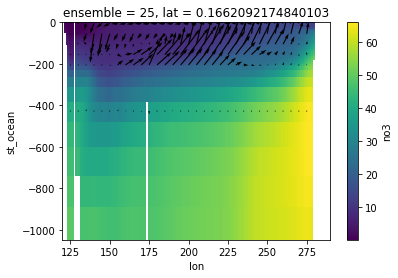

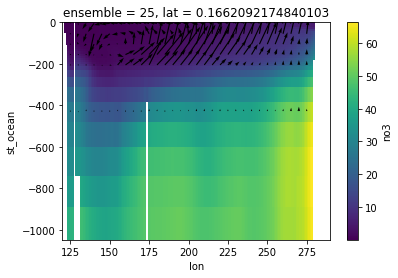

ValueError: operands could not be broadcast together with shapes (6,34) (1,2) 

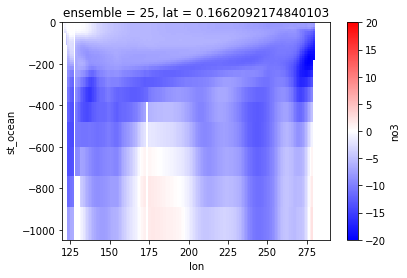

In [28]:
var='no3' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1989, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

nitrate_ew_pac80.plot()#(vmin=0,vmax=200)
plt.quiver(zc_80s.lon[sk],zc_80s.st_ocean[sk],zc_80s[sksk],vc_80s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac2020.plot()#(vmin=0,vmax=200)
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk],vc_2010s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac_tdiff.plot(cmap='bwr')#(vmin=-75,vmax=75,)
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk]-zc_80s[sksk],vc_2010s[sksk]- [sksk],scale=qscale)
plt.show()

In [ ]:
var='fe' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

nitrate_ew_pac80.plot()#(vmin=0,vmax=200)
plt.quiver(zc_80s.lon[sk],zc_80s.st_ocean[sk],zc_80s[sksk],vc_80s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac2020.plot()#(vmin=0,vmax=200)
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk],vc_2010s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac_tdiff.plot(cmap='bwr')#(vmin=-75,vmax=75,cmap='bwr')
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk]-zc_80s[sksk],vc_2010s[sksk]-vc_80s[sksk],scale=qscale)
plt.show()

In [ ]:
var='o2' #no3, fe
lat=0
ensemble=25

nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80


nitrate_ew_pac80.plot(vmin=0,vmax=200)
plt.quiver(zc_80s.lon[sk],zc_80s.st_ocean[sk],zc_80s[sksk],vc_80s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac2020.plot(vmin=0,vmax=200)
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk],vc_2010s[sksk],scale=qscale)
plt.show()
nitrate_ew_pac_tdiff.plot(vmin=-75,vmax=75,cmap='bwr')
plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk]-zc_80s[sksk],vc_2010s[sksk]-vc_80s[sksk],scale=qscale)
plt.show()

In [ ]:
varx=['dic','adic'] #no3, fe
for i,var in enumerate(varx):
    lat=0
    ensemble=25

    dic_ew_pac=eqpac[var].sel(ensemble=ensemble,lat=lat,method='nearest').sel(st_ocean=slice(0,1000))
    dic_ew_pac['st_ocean']=dic_ew_pac['st_ocean']*-1

    dic_ew_pac80=dic_ew_pac.sel(time=slice(cftime.DatetimeJulian(1970, 1, 1),cftime.DatetimeJulian(1990, 12, 31))).mean(dim='time')
    dic_ew_pac2020=dic_ew_pac.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
    dic_ew_pac_tdiff=dic_ew_pac2020-dic_ew_pac80

    dic_ew_pac80.plot()#(vmin=0,vmax=150)
    plt.quiver(zc_80s.lon[sk],zc_80s.st_ocean[sk],zc_80s[sksk],vc_80s[sksk],scale=qscale)
    plt.show()
    dic_ew_pac2020.plot()#(vmin=0,vmax=150)
    plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk],vc_2010s[sksk],scale=qscale)
    plt.show()
    dic_ew_pac_tdiff.plot()#(vmin=-100,vmax=100)
    plt.quiver(zc_2010s.lon[sk],zc_2010s.st_ocean[sk],zc_2010s[sksk]-zc_80s[sksk],vc_2010s[sksk]-vc_80s[sksk],scale=qscale)
    plt.show()
    
    if i==0:
        dic80=dic_ew_pac80
        dic20=dic_ew_pac2020
    elif i==1:
        adic80=dic_ew_pac80
        adic20=dic_ew_pac2020

In [ ]:
(adic80-dic80).plot(vmin=0,vmax=75)
plt.show()
(adic20-dic20).plot(vmin=0,vmax=75)
plt.show()


In [ ]:
# Try do the Latitudinal cross section, but need to fix the chunking maybe.
nitrate_ens_pac=eqpac.no3.sel(ensemble=25,lon=260,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_ens_pac['st_ocean']=nitrate_ens_pac['st_ocean']*-1
#nitrate_ens_pac.load()

In [ ]:
nitrate_ens_pac80=nitrate_ens_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time').chunk({'lat':1})

In [ ]:
nitrate_ens_pac80

In [ ]:
nitrate_ens_pac80.plot(vmin=0,vmax=70)

In [ ]:
nitrate_ens_pac2020=nitrate_ens_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')
nitrate_ens_pac2020.plot(vmin=0,vmax=70)

In [2]:
# Try do the Latitudinal cross section, but need to fix the chunking maybe.
nitrate_wns_pac=eqpac.no3.sel(ensemble=25,lon=160,method='nearest').sel(st_ocean=slice(0,1000))
nitrate_wns_pac['st_ocean']=nitrate_wns_pac['st_ocean']*-1
#nitrate_ens_pac.load()
nitrate_wns_pac80=nitrate_wns_pac.sel(time=slice(cftime.DatetimeJulian(1980, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time')
nitrate_wns_pac2020=nitrate_wns_pac.sel(time=slice(cftime.DatetimeJulian(2019, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')

NameError: name 'eqpac' is not defined

In [ ]:
nitrate_wns_pac80.plot(vmin=0,vmax=70)

In [ ]:
nitrate_wns_pac2020.plot(vmin=0,vmax=70)

In [15]:
#cluster.scale(cores=12)
cluster

In [13]:
# OK LETS TRY A CRAZY PLOT

# 1) Hovmoller of Surface 1000m aDIC-DIC) and 2) - (mean 1000m aDIC-DIC) between 1960 and 2020

In [11]:
cross_section=eqpac.sel(ensemble=25,st_ocean=slice(0,1000)).sel(lat=0,method='nearest').mean(dim='st_ocean')
#cross_section['st_ocean']=cross_section['st_ocean']*-1
adic_cross=cross_section.adic
dic_cross=cross_section.dic
anth_dic_cross=adic_cross-dic_cross

In [12]:
cluster

In [35]:
eqpac

,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
#adic_cross
anth_dic_cross.to_netcdf('../processed_data/anth_dic.nc')

In [18]:
anth_dic_cross=xr.open_dataset('../processed_data/anth_dic.nc').__xarray_dataarray_variable__

In [75]:
anth_dic_cross['time']=np.array(anth_dic_cross.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')

/local/v45/np1383/tmp/ipykernel_4136988/755239820.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  anth_dic_cross['time']=np.array(anth_dic_cross.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


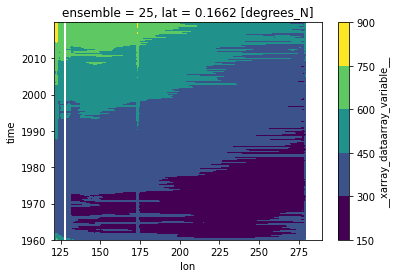

In [76]:
(anth_dic_cross*12).plot.contourf() #mgCanth/m3

In [20]:
anth_dic_cross

In [53]:
elnino

,Unnamed: 0,end,mei,start
0,0,1983-07-01,0.75,1982-06-01
1,1,1988-01-01,0.59,1986-07-01
2,2,1992-07-01,0.76,1991-09-01
3,3,1993-11-01,0.70,1992-09-01
4,4,1995-01-01,0.77,1994-07-01
5,5,1998-05-01,2.26,1997-05-01
6,6,2003-03-01,0.53,2002-08-01
7,7,2007-01-01,0.62,2006-08-01
8,8,2010-03-01,1.31,2009-10-01
9,9,2016-05-01,1.26,2015-05-01


In [58]:
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
#Process EP, CP and Nino events.

nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=cafe_sst_mean.time
#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

In [59]:
cp_events

array(['2002-12-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2003-02-01T00:00:00.000000000', '2003-03-01T00:00:00.000000000',
       '2003-04-01T00:00:00.000000000', '2003-05-01T00:00:00.000000000',
       '2004-05-01T00:00:00.000000000', '2004-06-01T00:00:00.000000000',
       '2004-07-01T00:00:00.000000000', '2004-08-01T00:00:00.000000000',
       '2004-09-01T00:00:00.000000000', '2004-10-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000'], dtype='datetime64[ns]')

ep
cp
nina
all time
neutral


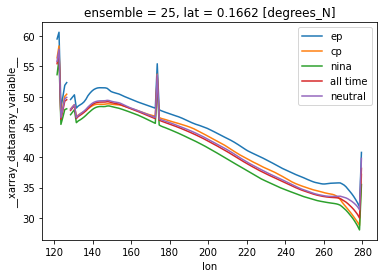

In [88]:
nametimes={'ep':ep_events,'cp':cp_events,'nina':nina_events,'all time':all_dates,'neutral':neutral_events}
for name in nametimes:
    print(name)
    dates=nametimes[name]
    anth_dic_cross.sel(time=dates).mean(dim='time').plot()
plt.legend(nametimes.keys())

dict_keys(['ep', 'cp', 'nina'])

In [71]:
anth_dic_cross.time

<xarray.DataArray 'time' (time: 720)>
array([cftime.DatetimeJulian(1960, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1960, 2, 15, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1960, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2019, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2019, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2019, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
    ensemble  int32 25
  * time      (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
    lat       float64 0.1662
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [65]:
nametimes['ep']

array(['2006-08-01T00:00:00.000000000', '2006-09-01T00:00:00.000000000',
       '2006-10-01T00:00:00.000000000', '2006-11-01T00:00:00.000000000',
       '2006-12-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000'], dtype='datetime64[ns]')

TypeError: '>' not supported between instances of 'float' and 'Text'

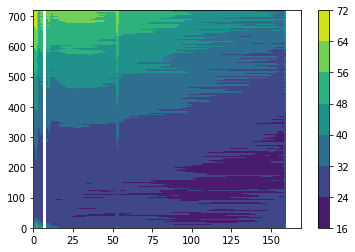

In [61]:
plt.contourf(anth_dic_cross,cmap='viridis')
plt.colorbar()
plt.yticks(plt.yticks(),anth_dic_cross.time[np.arange(0,len(anth_dic_cross.time),80)].values)

In [41]:
len(ticks[1])

9

In [44]:
anth_dic_cross.time[np.arange(0,len(anth_dic_cross.time),80)]

<xarray.DataArray 'time' (time: 9)>
array([cftime.DatetimeJulian(1960, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1966, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1973, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1980, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1986, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1993, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2000, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2006, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2013, 5, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
    ensemble  int32 25
  * time      (time) object 1960-01-16 12:00:00 ... 2013-05-16 12:00:00
    lat       float64 0.1662
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time